Ingesta de datos

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 

In [3]:
adult = fetch_ucirepo(id=2) 

In [4]:
df = pd.concat([adult.data.features, adult.data.targets], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
mapeo_sex = {'Female': 1, 'Male': 0}
df['sex'] = df['sex'].map(mapeo_sex)

In [6]:
# Columnas categóricas a codificar
columnas_categoricas = ['workclass','education','marital-status','occupation','relationship','race','native-country']

# Inicializar codificadores
encoders = {}
for col in columnas_categoricas:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le  # Guardamos el encoder para posibles decodificaciones posteriores

In [7]:
# 1) Normaliza la etiqueta: quita espacios y punto final
df['income_clean'] = (
    df['income']
      .astype(str)
      .str.strip()                 # quita espacios al inicio/fin
      .str.replace(r'\.$', '', regex=True)   # elimina punto final si existe
)

# Verifica
print(df['income_clean'].value_counts(dropna=False))

#Reemplazar 
df['income_bin'] = df['income_clean'].map({'>50K': 1, '<=50K': 0})

# Comprueba que no queden NaN por categorías no previstas
print(df['income_bin'].value_counts(dropna=False))

income_clean
<=50K    37155
>50K     11687
Name: count, dtype: int64
income_bin
0    37155
1    11687
Name: count, dtype: int64


In [8]:
# Eliminar la columna 'income' y renombrar 'income_bin' a 'income'
df = df.drop(columns=["income"])
df = df.drop(columns=["income_clean"])
df = df.rename(columns={"income_bin": "income"})

In [9]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,0,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,0,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,0,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,0,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,1,0,0,40,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,4,215419,9,13,0,10,1,4,1,0,0,36,39,0
48838,64,9,321403,11,9,6,15,2,2,0,0,0,40,39,0
48839,38,4,374983,9,13,2,10,0,4,0,0,0,50,39,0
48840,44,4,83891,9,13,0,1,3,1,0,5455,0,40,39,0


In [10]:
df_tracking = df.copy()

In [ ]:
#valores_unicos = df["workclass"].unique()
#print(valores_unicos)


[7 6 4 1 2 0 5 8 3 9]


Denifir columnas a modelar

In [11]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
import seaborn as sns

<Axes: xlabel='income', ylabel='count'>

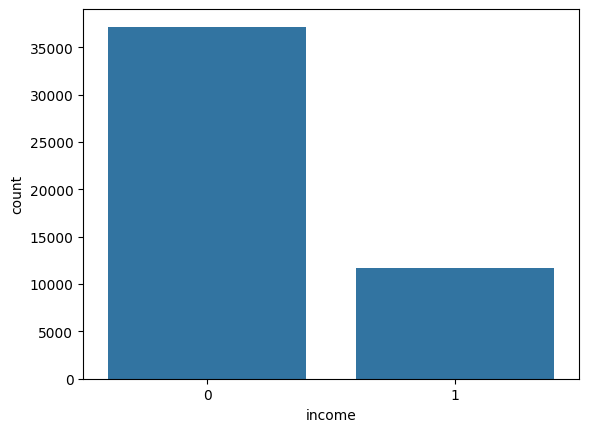

In [12]:
sns.countplot(df, x = "income" )

In [13]:
X = df.drop(["income"],axis=1)
y = df['income']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Accuracy : 0.8536
F1 Score :0.6675
Precision :0.7311
Sensitividad :0.6141
Especificidad :0.9289


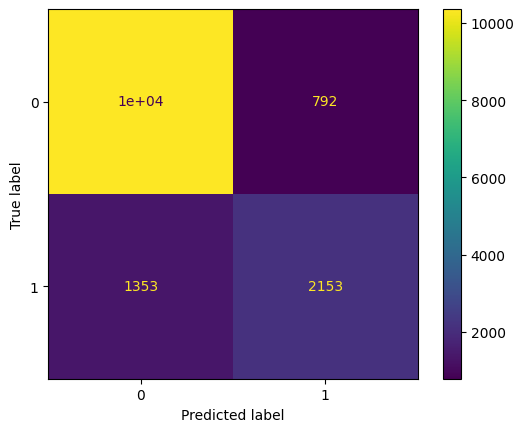

In [15]:
#Definir el modelo
modelo_random = RandomForestClassifier(random_state=42)

#Entrenar el modelo
modelo_random.fit(X_train, y_train)

#Predecir
y_pred = modelo_random.predict(X_test)

#Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Calcular metrica F1score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitividad = recall_score(y_test, y_pred)
especificidad = tn / (tn + fp)

#Imprimir metrica
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score :{f1:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Sensitividad :{sensitividad:.4f}")
print(f"Especificidad :{especificidad:.4f}")

#Mostrar matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

MLFLOW

In [16]:
from sklearn.feature_extraction import DictVectorizer
import pickle

In [17]:
categorical = ['age', 'sex']
numerical = ["income"]

In [36]:
df_train, df_val = train_test_split(df, test_size=0.4, random_state=42)

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df_train = df_train.copy()
df_val   = df_val.copy()
df_train["categorical_dict"] = df_train[categorical].to_dict(orient="records")
df_val["categorical_dict"]   = df_val[categorical].to_dict(orient="records")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", DictVectorizer(), "categorical_dict"),
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), numerical),
    ]
)

X_train = preprocessor.fit_transform(df_train)
y_train = df_train["income"].values
X_val   = preprocessor.transform(df_val)
y_val   = df_val["income"].values

Antes ejecutar esto por terminal donde se encuentra el notebook

mlflow server --backend-store-uri sqlite:///backend.db

In [26]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [27]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://127.0.0.1:5000'


In [28]:
mlflow.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1759607036566, experiment_id='0', last_update_time=1759607036566, lifecycle_stage='active', name='Default', tags={}>]

In [33]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error
import numpy as np

experiment_name = "Ingresos_Clasificacion"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    rf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)


2025/10/04 14:57:52 INFO mlflow.tracking.fluent: Experiment with name 'Ingresos_Clasificacion' does not exist. Creating a new experiment.


🏃 View run beautiful-pig-896 at: http://127.0.0.1:5000/#/experiments/2/runs/4b4bf8120d80443fa88a040c6d01bda8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


Probando otro modelo

In [34]:
import xgboost as xgb

experiment_name = "Ingresos_Xgboost"
mlflow.set_experiment(experiment_name)
with mlflow.start_run():
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

2025/10/04 14:58:12 INFO mlflow.tracking.fluent: Experiment with name 'Ingresos_Xgboost' does not exist. Creating a new experiment.


🏃 View run fearless-snipe-172 at: http://127.0.0.1:5000/#/experiments/3/runs/55b717a8b57b41f292bd5318cc7b92c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


Probando autologgin

In [35]:
import mlflow

experiment_name = "Ingresos_autolog"
mlflow.set_experiment(experiment_name)
mlflow.autolog()

with mlflow.start_run():
    rf = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

2025/10/04 14:58:39 INFO mlflow.tracking.fluent: Experiment with name 'Ingresos_autolog' does not exist. Creating a new experiment.
2025/10/04 14:58:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/04 14:58:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2025/10/04 14:58:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run spiffy-grub-297 at: http://127.0.0.1:5000/#/experiments/4/runs/c0de723e9876430487f322ba07c8360e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/4


duration-prediction

mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 --port 5000

In [39]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Ingresos-experiment")

2025/10/04 15:46:58 INFO mlflow.tracking.fluent: Experiment with name 'Ingresos-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/eaop0/OneDrive/Desktop/Especializacion/Segundo_Semestre/Aprendizaje_Nube/Clon_Entregable/ProyectoMLOps/src/notebook/mlruns/1', creation_time=1759610818041, experiment_id='1', last_update_time=1759610818041, lifecycle_stage='active', name='Ingresos-experiment', tags={}>

In [40]:
def read_dataframe(filename):
    #TODO add docstrings in al functions
    df = pd.read_parquet(filename)

    df['income'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['age', 'sex']
    df[categorical] = df[categorical].astype(str)

    df['AG_SE'] = df['age'] + '_' + df['sex']

    return df

In [53]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,0,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,0,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,0,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,0,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,1,0,0,40,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,4,215419,9,13,0,10,1,4,1,0,0,36,39,0
48838,64,9,321403,11,9,6,15,2,2,0,0,0,40,39,0
48839,38,4,374983,9,13,2,10,0,4,0,0,0,50,39,0
48840,44,4,83891,9,13,0,1,3,1,0,5455,0,40,39,0


In [41]:
df_train_orquesta, df_val_orquesta = train_test_split(df, test_size=0.4, random_state=42)

In [44]:
categorical = ['age','sex'] 
numerical = ['income']

dv = DictVectorizer()

train_dicts = df_train_orquesta[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val_orquesta[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [45]:
target = 'income'
y_train_orquesta = df_train[target].values
y_val_orquesta = df_val[target].values

In [51]:
from pathlib import Path
from sklearn.metrics import root_mean_squared_error

In [48]:
models_folder = Path('models')
models_folder.mkdir(exist_ok=True)

In [52]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train_orquesta)
    valid = xgb.DMatrix(X_val, label=y_val_orquesta)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=30,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val_orquesta, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:0.38678
[1]	validation-rmse:0.34970
[2]	validation-rmse:0.31618
[3]	validation-rmse:0.28588
[4]	validation-rmse:0.25847
[5]	validation-rmse:0.23370
[6]	validation-rmse:0.21130
[7]	validation-rmse:0.19104
[8]	validation-rmse:0.17273
[9]	validation-rmse:0.15618
[10]	validation-rmse:0.14121
[11]	validation-rmse:0.12767
[12]	validation-rmse:0.11543
[13]	validation-rmse:0.10437
[14]	validation-rmse:0.09436
[15]	validation-rmse:0.08532
[16]	validation-rmse:0.07714
[17]	validation-rmse:0.06975
[18]	validation-rmse:0.06306
[19]	validation-rmse:0.05702
[20]	validation-rmse:0.05155
[21]	validation-rmse:0.04661
[22]	validation-rmse:0.04214
[23]	validation-rmse:0.03810
[24]	validation-rmse:0.03445
[25]	validation-rmse:0.03115
[26]	validation-rmse:0.02816
[27]	validation-rmse:0.02546
[28]	validation-rmse:0.02302
[29]	validation-rmse:0.02082


c:\Users\eaop0\OneDrive\Desktop\Especializacion\Segundo_Semestre\Aprendizaje_Nube\Clon_Entregable\ProyectoMLOps\.venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:01:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
2025/10/04 16:01:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 16:01:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\eaop0\OneDrive\Desktop\Especializacion\Segundo_Semestre\Aprendizaje_Nube\Clon_Entregable\ProyectoMLOps\.venv\Lib\site-packages\mlflow\xgboost\__init__.py:169: UserWarning: [16:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/10/04

🏃 View run colorful-koi-78 at: http://localhost:5000/#/experiments/1/runs/9180fa70d3ef442fbb2d33be480c4e3a
🧪 View experiment at: http://localhost:5000/#/experiments/1
